In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard


# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline


from PIL import Image
from collections import defaultdict

dataset_path = r'C:\Users\Pablo Fontanessi\Desktop\ML\train'

# Variables globales
TIPO_IMAGEN = "buildings", "forest", "glacier","mountain","sea","street" 
# configurar de acuerdo a dónde bajaron los sets de imágenes
#TRAIN_DIR = r'C:\Users\Pablo Fontanessi\Desktop\ML\train'
TEST_DIR = r'C:\Users\Pablo Fontanessi\Desktop\ML\test'
SIZE = 32



# 1. Análisis exploratorio sobre el conjunto de datos.

## Volumetría de los datos

In [2]:
classes = os.listdir(dataset_path)
image_count = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_count[class_name] = len(os.listdir(class_path))

image_count_df = pd.DataFrame(list(image_count.items()), columns=['Class', 'Image Count'])
print(image_count_df)

total_images = image_count_df['Image Count'].sum()
print(f"\nTotal de imágenes en el dataset: {total_images} \n")

size_distribution = defaultdict(int)

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    
    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)
        size_distribution[image.size] += 1

for size, count in size_distribution.items():
    print(f"Size: {size}, Count: {count}")

       Class  Image Count
0  buildings         2191
1     forest         2271
2    glacier         2404
3   mountain         2512
4        sea         2274
5     street         2382

Total de imágenes en el dataset: 14034 

Size: (150, 150), Count: 13986
Size: (150, 124), Count: 1
Size: (150, 113), Count: 7
Size: (150, 108), Count: 2
Size: (150, 133), Count: 1
Size: (150, 115), Count: 1
Size: (150, 135), Count: 3
Size: (150, 136), Count: 2
Size: (150, 110), Count: 1
Size: (150, 105), Count: 1
Size: (150, 111), Count: 3
Size: (150, 120), Count: 1
Size: (150, 149), Count: 1
Size: (150, 143), Count: 2
Size: (150, 146), Count: 2
Size: (150, 134), Count: 2
Size: (150, 142), Count: 2
Size: (150, 123), Count: 2
Size: (150, 119), Count: 1
Size: (150, 102), Count: 1
Size: (150, 76), Count: 1
Size: (150, 97), Count: 1
Size: (150, 144), Count: 2
Size: (150, 103), Count: 1
Size: (150, 100), Count: 1
Size: (150, 141), Count: 1
Size: (150, 145), Count: 1
Size: (150, 81), Count: 1
Size: (150, 147), C

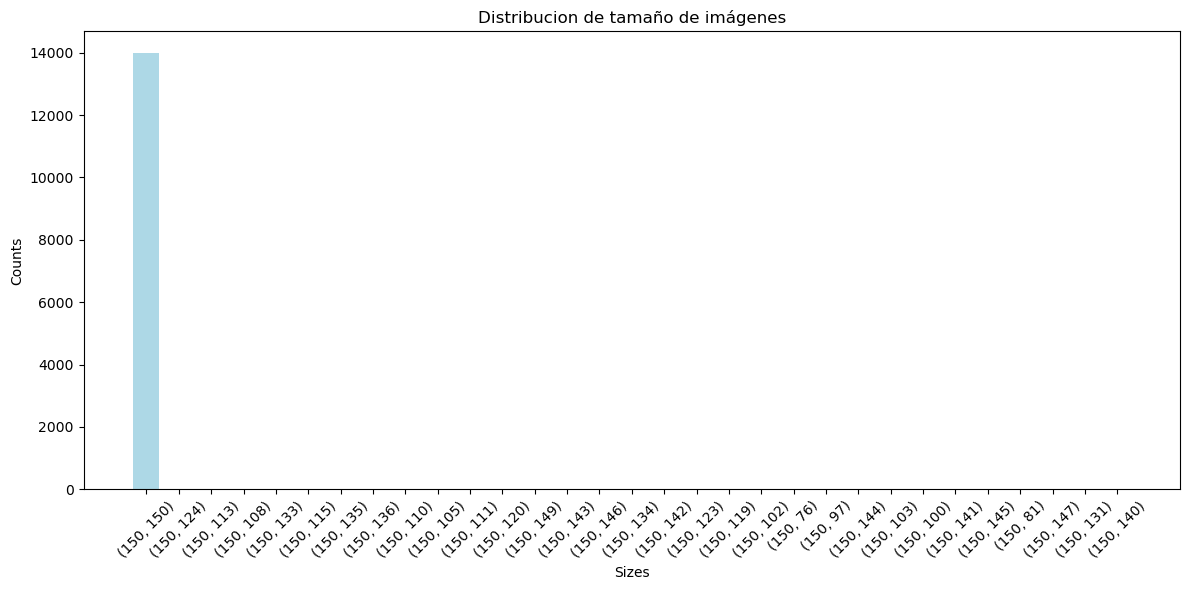

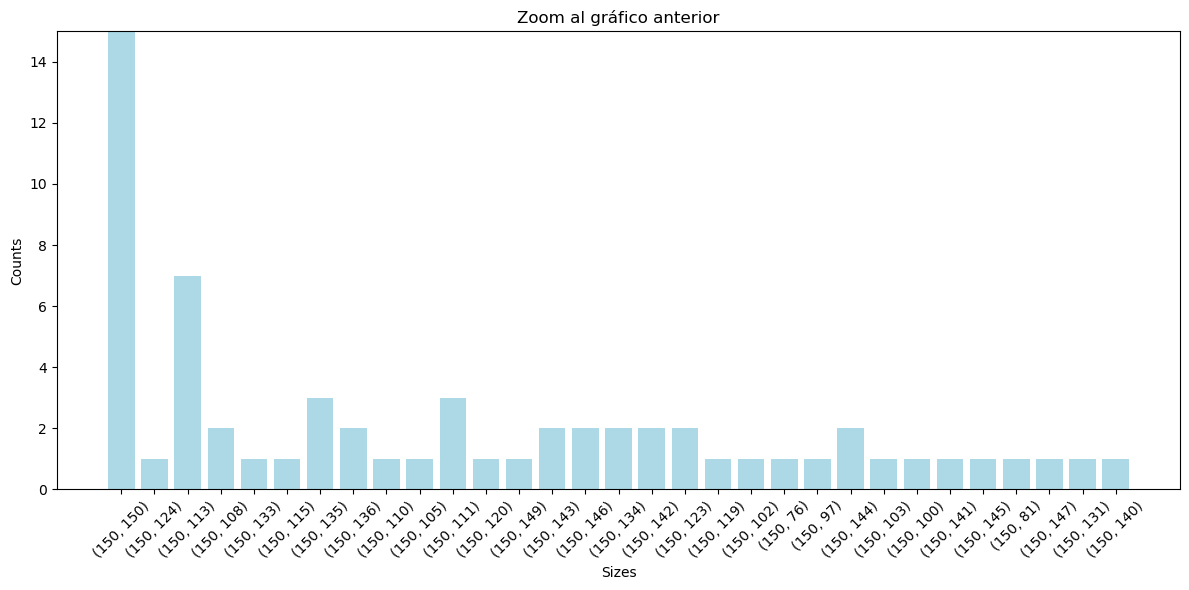

In [3]:
sizes = list(size_distribution.keys())
counts = list(size_distribution.values())

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')
plt.title('Distribucion de tamaño de imágenes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.bar([str(size) for size in sizes], counts, color='lightblue')
plt.xlabel('Sizes')
plt.ylabel('Counts')

plt.ylim(0, 15)
plt.title('Zoom al gráfico anterior')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Estructura y tipo de las imágenes

In [4]:
def show_examples(path, num_classes=5, images_per_class=3):
    classes = random.sample(os.listdir(path), min(num_classes, len(os.listdir(path))))
    fig, axs = plt.subplots(num_classes, images_per_class, figsize=(15, 3*num_classes))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        images = random.sample([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg'))], images_per_class)
        
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(class_name, loc='left')
    
    plt.tight_layout()
    plt.show()

Clase: buildings, Imagen: 8129.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: forest, Imagen: 16830.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: glacier, Imagen: 8741.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: mountain, Imagen: 3657.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: sea, Imagen: 9761.jpg, Tamaño: (150, 150), Formato: JPEG
Clase: street, Imagen: 10916.jpg, Tamaño: (150, 150), Formato: JPEG


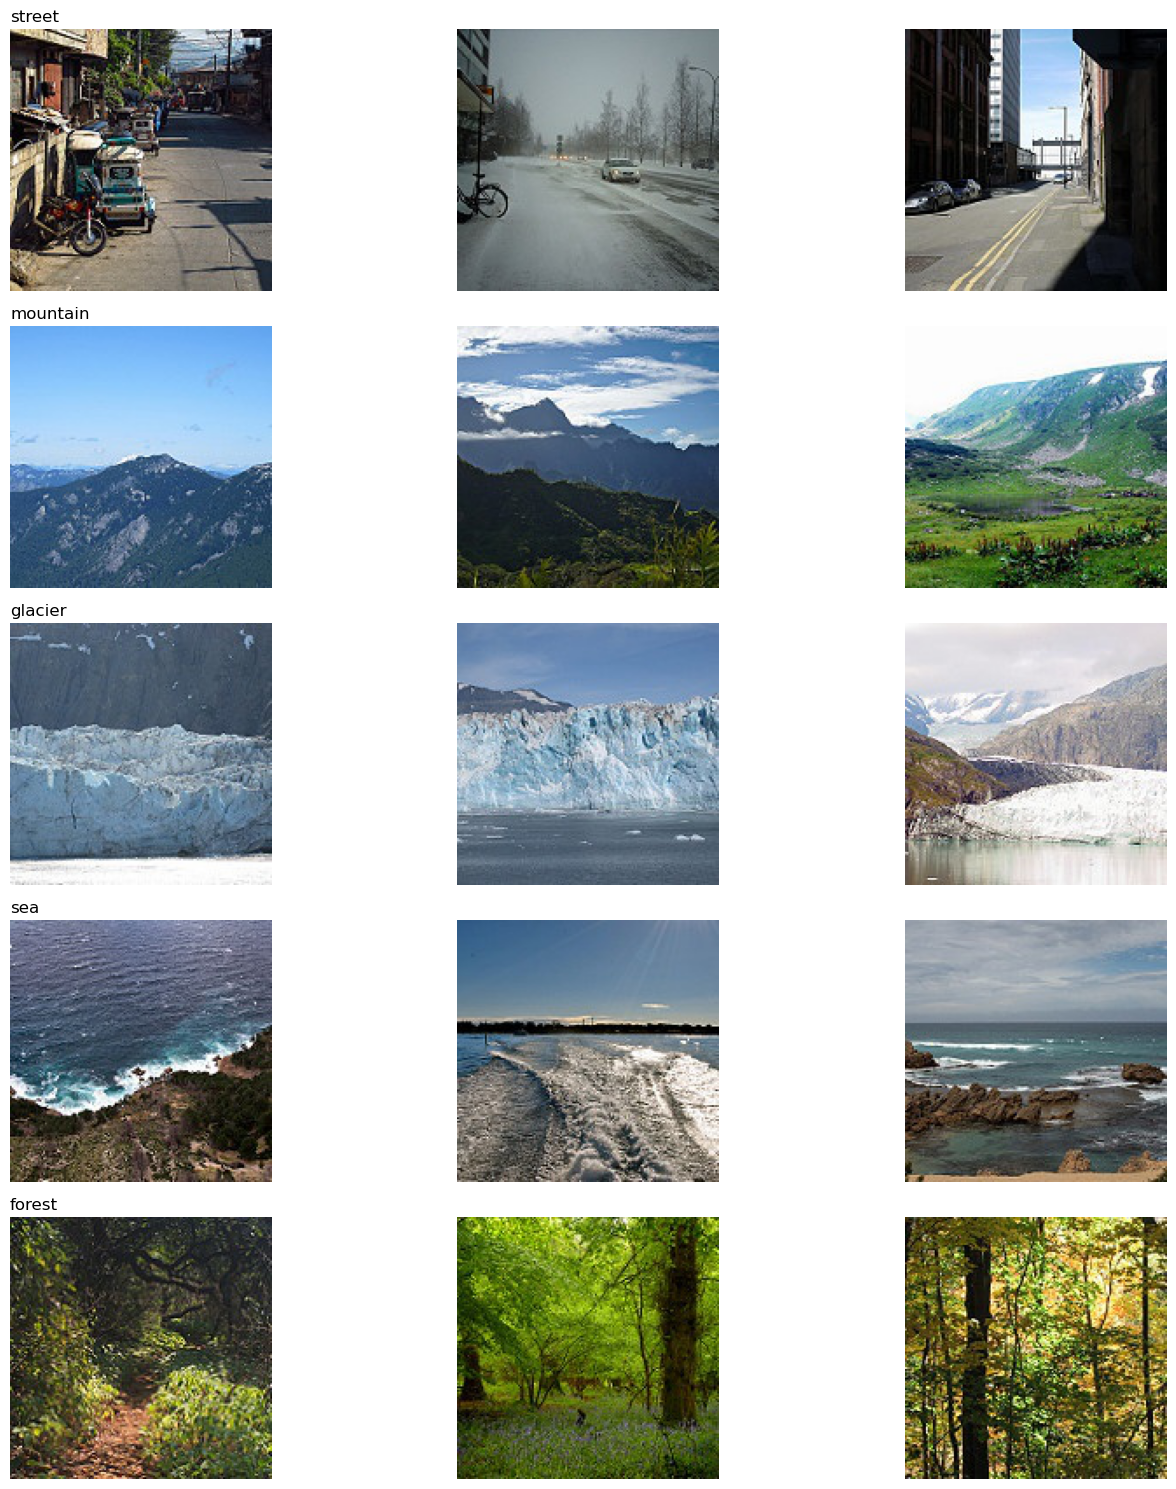

In [5]:
image_sizes = []
image_formats = []
random_images = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(class_path)
    random_image_file = random.choice(image_files)
    random_images.append((class_name, random_image_file))  # Guardar el nombre de la imagen
    image = Image.open(os.path.join(class_path, random_image_file))
    image_sizes.append(image.size)
    image_formats.append(image.format)

for i, (class_name, image_file) in enumerate(random_images):
    print(f"Clase: {class_name}, Imagen: {image_file}, Tamaño: {image_sizes[i]}, Formato: {image_formats[i]}")

show_examples(dataset_path)

## Distribución de la variable a predecir

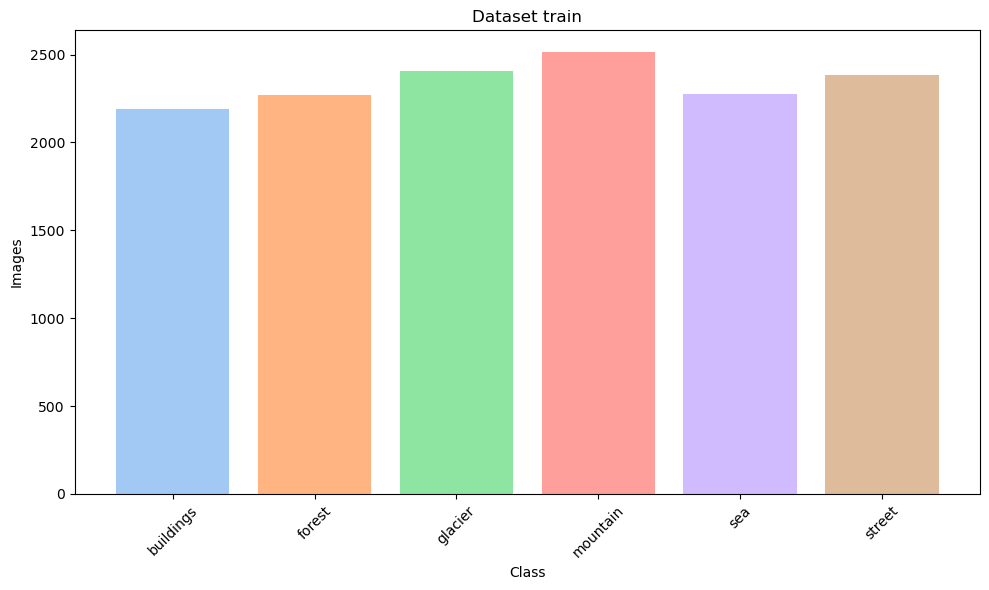

In [6]:
class_counts = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    # Contar el número de archivos de imagen en la carpeta
    num_images = len(os.listdir(class_path))
    class_counts[class_name] = num_images

colors = sns.color_palette('pastel', len(classes))

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color=colors)
plt.xlabel('Class')
plt.ylabel('Images')
plt.title('Dataset train')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Modelado

## Comparativa de distintas arquitecturas de redes neuronales (ej: MLP simple y Convolucional, variando cantidad de capas, filtros, etc.).

(opcional) Prueba de técnicas avanzadas: aumentación de datos, modelos pre-entrenados, incorporación de otros conjuntos de datos similares para el entrenamiento, etc.

Lo primero que vamos a hacer es crear datasets de imágenes para Keras, usando sus propias herramientas (un ImageDataGenerator que es una especie de "lector" de imágenes de disco):

In [2]:
images_reader = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    #width_shift_range=0.3,
    #height_shift_range=0.3,
    brightness_range=(0.5, 1.5),
    
)

READ_PARAMS = dict(
    class_mode="categorical",  
    classes=TIPO_IMAGEN,  
    target_size=(SIZE, SIZE),  
    color_mode="rgb",  
)

class_names = os.listdir(dataset_path)
image_paths = []
labels = []

for class_name in class_names:
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
        for img_file in os.listdir(class_folder):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(class_name)  


train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,  
    random_state=42,
    stratify=labels  
)


train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_paths, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    **READ_PARAMS
)


val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_paths, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    **READ_PARAMS
)

Found 8420 validated image filenames belonging to 6 classes.
Found 5614 validated image filenames belonging to 6 classes.


In [3]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (SIZE, SIZE, 3)

# MLP SIMPLE

In [ ]:
# MLP simple
model = Sequential([
    Input(input_shape),
    
    Flatten(),

    Dense(500, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # O cualquier otra función de pérdida adecuada
    metrics=['accuracy']  # Añadir 'accuracy' aquí
)


In [ ]:
model.summary()

In [4]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

# Entreno

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

In [ ]:
print(history.history.keys())

In [ ]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# MLP avanzado

In [7]:
# MLP simple
model = Sequential([
    Input(input_shape),
    Flatten(),
    Dense(256, activation='relu'), #cambio funcion activacion y menos densidad 
    Dropout(0.35), #Mas dropout
    Dense(512, activation='relu'),#nueva capa
    Dropout(0.4), #Mas dropout
    Dense(1024, activation='relu'),#nueva capa
    Dropout(0.5), #Mas dropout
    Dense(512, activation='relu'),#nueva capa
    Dropout(0.4), #menos dropout
    Dense(512, activation='relu'),#nueva capa
    Dropout(0.4), 
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # O cualquier otra función de pérdida adecuada
    metrics=['accuracy']  # Añadir 'accuracy' aquí
)

model.summary()

# Definir mas callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.001)


# Combinar todos los callbacks en una lista
callbacks = [early_stopping, checkpoint, reduce_lr]


history = model.fit(
    train_generator,
    epochs=30, # Número de épocas
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               786688    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)             

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 264 steps, validate for 176 steps
Epoch 1/30
264/264 [==============================] - 8s 29ms/step - loss: 1.7605 - accuracy: 0.2362 - val_loss: 1.6153 - val_accuracy: 0.3033
Epoch 2/30
264/264 [==============================] - 7s 27ms/step - loss: 1.6147 - accuracy: 0.3102 - val_loss: 1.4983 - val_accuracy: 0.3985
Epoch 3/30
264/264 [==============================] - 7s 27ms/step - loss: 1.5530 - accuracy: 0.3517 - val_loss: 1.5406 - val_accuracy: 0.3869
Epoch 4/30
264/264 [==============================] - 7s 27ms/step - loss: 1.5195 - accuracy: 0.3714 - val_loss: 1.5521 - val_accuracy: 0.3716
Epoch 5/30
264/264 [==============================] - 7s 27ms/step - loss: 1.5133 - accuracy: 0.3795 - val_loss: 1.5196 - val_accuracy: 0.3885
Epoch 6/30
264/264 [==============================] - 7s 27ms/step - loss: 1.5042 - accuracy: 0.3895 - val_loss: 1.4474 - val_accuracy: 0.4498
Epoch 7/30
264/264 [==============================] - 7s 27ms/step - loss: 1.4746 - accuracy: 0.41

# Convolucional simple

In [ ]:
model = Sequential([
    Input(input_shape),

    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=10, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(100, activation='tanh'),
    Dropout(0.25),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

In [ ]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Convolucional usando convoluciones ya entrenadas de VGG16

In [ ]:
pretrained_model = VGG16(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model = Sequential([
    pretrained_model,

    Flatten(),

    Dense(100, activation='tanh'),
    Dense(100, activation='tanh'),
    
    Dense(len(TIPO_IMAGEN), activation='softmax'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [ ]:
model.summary()

In [ ]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[OurCustomCallback()]
)

In [ ]:
# Graficar la precisión
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# 3. Conclusiones

Desarrollar las conclusiones finales a las que llegaron a partir de los experimentos, destacando la interpretación de los resultados obtenidos.